# Imports

In [1]:
import os
import json
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
import pandas as pd
pd.options.display.max_columns = None

In [4]:
%run ../utils/__init__.py
%run ../metrics/__init__.py

# Functions

In [5]:
%run ../utils/files.py

In [6]:
def load_metrics(run_id):
    folder = get_results_folder(run_id, assert_exists=True)
    filepath = os.path.join(folder, 'metrics.json')
    
    if not os.path.isfile(filepath):
        raise FileNotFoundError(filepath)

    with open(filepath, 'r') as f:
        return json.load(f)

In [7]:
def load_outputs_csv(run_id):
    folder = get_results_folder(run_id, assert_exists=True)
    filepath = os.path.join(folder, 'outputs.csv')
    
    if not os.path.isfile(filepath):
        raise FileNotFoundError(filepath)
    
    return pd.read_csv(filepath)

# Compare multiple models

In [8]:
from collections import defaultdict
import re

In [9]:
%run ../datasets/common/__init__.py
%run ../utils/plots.py

In [10]:
DISEASES = CXR14_DISEASES
# DISEASES = VINBIG_DISEASES
len(DISEASES)

14

## Load metadata

In [11]:
%run ../models/checkpoint/__init__.py

In [12]:
# run_name = '0201_180839_cxr14_tfs-small_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1_noes'
run_name = '0309_215826'
debug_run = False

In [13]:
meta = load_metadata(RunId(run_name, debug_run, task='rg'))
meta

{'cnn_kwargs': {'model_name': 'mobilenet-v2',
  'labels': ['Atelectasis',
   'Cardiomegaly',
   'Effusion',
   'Infiltration',
   'Mass',
   'Nodule',
   'Pneumonia',
   'Pneumothorax',
   'Consolidation',
   'Edema',
   'Emphysema',
   'Fibrosis',
   'Pleural_Thickening',
   'Hernia'],
  'imagenet': True,
  'freeze': False,
  'gpool': 'max',
  'fc_layers': []},
 'decoder_kwargs': {'decoder_name': 'lstm-v2',
  'vocab_size': 1684,
  'embedding_size': 100,
  'hidden_size': 100,
  'features_size': 1280,
  'teacher_forcing': True},
 'opt_kwargs': {'lr': 0.001},
 'lr_sch_kwargs': None,
 'dataset_kwargs': {'dataset_name': 'iu-x-ray',
  'max_samples': None,
  'image_size': [256, 256],
  'batch_size': 40,
  'num_workers': 4,
  'masks': False,
  'frontal_only': True,
  'vocab': {'PAD': 0,
   'START': 2,
   'END': 1,
   'UNK': 3,
   '.': 4,
   'the': 5,
   'cardiac': 6,
   'silhouette': 7,
   'and': 8,
   'mediastinum': 9,
   'size': 10,
   'are': 11,
   'within': 12,
   'normal': 13,
   'limits

In [44]:
meta['hparams']

{'pretrained_cnn': '0123_174651', 'batch_size': 40}

In [14]:
load_metadata(RunId('0123_174651', debug=False, task='cls'))

{'model_kwargs': {'model_name': 'mobilenet-v2',
  'labels': ['Atelectasis',
   'Cardiomegaly',
   'Effusion',
   'Infiltration',
   'Mass',
   'Nodule',
   'Pneumonia',
   'Pneumothorax',
   'Consolidation',
   'Edema',
   'Emphysema',
   'Fibrosis',
   'Pleural_Thickening',
   'Hernia'],
  'imagenet': True,
  'freeze': False,
  'gpool': 'max',
  'fc_layers': []},
 'opt_kwargs': {'lr': 0.0001},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.1,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_name': 'wbce', 'loss_kwargs': {}, 'batch_size': 20},
 'other_train_kwargs': {'early_stopping': False,
  'early_stopping_kwargs': {'patience': 10,
   'metric': 'roc_auc',
   'min_delta': 0},
  'lr_sch_metric': 'roc_auc',
  'grad_cam': False,
  'grad_cam_thresh': 0.5,
  'hint': True},
 'dataset_kwargs': {'dataset_name': 'cxr14',
  'labels': None,
  'max_samples': None,
  'batch_size': 20,
  'image_size': [256, 256],
  'frontal_only': True,
  'num_workers': 2,
  'nor

## CMs

In [ ]:
# TODO: implement for multiple dataset_types at the same time (see function below)
# FIXME: update for RunId stuff

def plot_cms_multiple_runs(run_names, dataset_type='train', percentage=False):
    errors = defaultdict(list)

    n_runs = len(run_names)
    n_diseases = len(diseases)

    plt.figure(figsize=(n_runs*5, n_diseases * 3))

    for i_run, run_name in enumerate(run_names):
        results = load_metrics(run_name)      

        # for dataset_type in dataset_types:
        if dataset_type not in results:
            errors['dataset-type-not-found'].append(run_name)
            continue

        metrics = results[dataset_type]

        for i_disease, disease in enumerate(diseases):
            key = f'cm_{disease}'
            if key not in metrics:
                errors[f'{key}-not-in-metrics'].append(run_name)
                continue

            cm = metrics[key]

            subplt_index = n_runs * i_disease + i_run + 1
            plt.subplot(n_diseases, n_runs, subplt_index)

            title = shorten_run_name(run_name) if i_disease == 0 else None
            plot_cm(cm, title=title, percentage=percentage,
                    xlabel=(i_disease == n_diseases-1),
                    ylabel=False,
                   )
            plt.ylabel(disease)


        print(run_name)
    print(f'Dataset type: {dataset_type}')
    
    n_errors = sum(v for v in errors.values())
    if n_errors > 0:
        print('Errors: ', {k: len(v) for k, v in errors.items()})

In [ ]:
run_names = [
#     '0123_174651_cxr14_mobilenet-v2_lr0.0001_hint_normS_size256_sch-roc_auc-p5-f0.1_noes',
    '0125_211742_cxr14_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes',
#     '0128_092013_cxr14-clahe_densenet-121-v2_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1_noes',
#     '0128_165641_cxr14-clahe_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes',
    '0129_150255_cxr14_densenet-121-v2_lr0.0001_hint_balance_normS_size200_sch-roc_auc-p5-f0.1_noes',
    '0129_150753_cxr14_densenet-121-v2_lr0.0001_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',
]

In [ ]:
plot_cms_multiple_runs(run_names, 'test', percentage=True)

## Prediction distribution

In [15]:
def plot_distributions(run_ids, dataset_types='test', density=True):
    # FIXME: load this from the metadata?
    diseases = list(DISEASES)
    
    if isinstance(dataset_types, str):
        dataset_types = (dataset_types,)
    
    n_diseases = len(diseases)
    n_runs = len(run_ids)
    n_dtypes = len(dataset_types)
    
    n_rows = n_diseases
    n_cols = n_runs * n_dtypes
    
    plt.figure(figsize=((n_runs*n_dtypes)*5, n_diseases*3))
    
    # To set y_lim the same for horizontal neighbors:
    max_upper_y_by_disease = np.zeros(len(diseases))
    axes_by_disease = {i: [] for i in range(len(diseases))}
    
    for i_run, run_id in enumerate(run_ids):
        df = load_outputs_csv(run_id)
        metrics = load_metrics(run_id)
        
        print(run_id.name)
        
        # Print metrics
        for dataset_type in metrics.keys():
            sub_metrics = metrics[dataset_type]
            macro_roc_auc = sub_metrics.get('roc_auc', -1)
            print(f'\t{dataset_type}: roc-auc={macro_roc_auc:.2f}')
        
        for i_dtype, dataset_type in enumerate(dataset_types):
            sub_df = df[df['dataset_type'] == dataset_type]
            sub_metrics = metrics.get(dataset_type, {})
    
            upper_y_by_disease = []
            for i_disease, disease in enumerate(diseases):
                gt_col = f'{disease}-gt'
                pred_col = f'{disease}-pred'
                cols = [gt_col, pred_col]

                if gt_col not in sub_df.columns:
                    continue
                
                disease_df = sub_df[cols]

                pos_samples = disease_df[disease_df[gt_col] == 1][pred_col]
                neg_samples = disease_df[disease_df[gt_col] == 0][pred_col]

                # Plot
                subplt_index = (n_runs * n_dtypes) * i_disease + i_run * n_dtypes + i_dtype + 1
                plt.subplot(n_rows, n_cols, subplt_index)

                if i_disease == 0: plt.title(f'{run_id.short_name} ({dataset_type})')

                plt.hist(pos_samples, fc=(1, 0, 0, 0.4), label='pos', density=density)
                plt.hist(neg_samples, fc=(0, 0, 1, 0.4), label='neg', density=density)

                if i_disease == n_diseases-1: plt.xlabel('Prediction value')
                
                roc_auc = sub_metrics.get(f'roc_auc_{disease}')
                plt.ylabel(f'{disease} (ROC-AUC={roc_auc:.2f})')

                plt.legend()
                
                current_axes = plt.gca()
                _, upper_y = current_axes.get_ylim()
                upper_y_by_disease.append(upper_y)
                axes_by_disease[i_disease].append(current_axes)

            max_upper_y_by_disease = np.maximum(max_upper_y_by_disease, upper_y_by_disease)
            
            
    # Correctly set ylims
    for i_disease in range(len(diseases)):
        upper_y = max_upper_y_by_disease[i_disease]
        axes = axes_by_disease[i_disease]
        
        for ax in axes:
            ax.set_ylim(0, upper_y)

In [33]:
run_ids = [
# '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1',
# '0125_211742_cxr14_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes',
# '0201_180839_cxr14_tfs-small_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1_noes',
# '0203_163918_cxr14_tiny-densenet_lr0.0001_gavg_aug-No-Finding-cls0_normS_size256_sch-roc_auc-p3-f0.1',
# '0203_185555_cxr14_tiny-densenet_lr0.0001_hint_gavg_normS_size256_sch-roc_auc-p3-f0.1',

# Small examples:
# '0222_230258',
# '0219_175036',
    
# Balance examples:
# '0201_180818_cxr14_tfs-small_lr0.0001_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',
# '0201_143527_cxr14_mobilenet-v2_lr0.0001_noig_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',

# Bad examples:
# '0202_164454_cxr14_tiny-densenet_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1',
    
    # Good examples:
#     RunId('0317_110119', debug=False, task='cls'),
#     RunId('0318_154252', debug=False, task='cls'),
#     RunId('0406_003450', debug=False, task='cls-seg'),

    # Previous best:
    # RunId('0123_174651', debug=False, task='cls'),
    
    # Best two:
    # RunId('0311_101753', debug=False, task='cls'),
    RunId('0402_062551', debug=False, task='cls-seg'),
    
    # Two CL candidates:
    # RunId('0410_145310', debug=False, task='cls'),
    # RunId('0413_174536', debug=False, task='cls'),
]

0402_062551_cxr14_densenet-121-cls-seg_drop0.3_normD_size256_lr5e-05_shuffle_wd0.002_sch-roc_auc-p3-f0.5_best-roc_auc_cl-wbce_seg-w
	test: roc-auc=0.81
	train: roc-auc=0.89
	val: roc-auc=0.84
0410_145310_cxr14_densenet-121-v2_drop0.3_aug1-double_normS_wd0.01_size256_lr5e-05_sch-roc_auc-p1-f0.5-c3_shuffle
	test: roc-auc=0.80
	train: roc-auc=0.87
	val: roc-auc=0.83


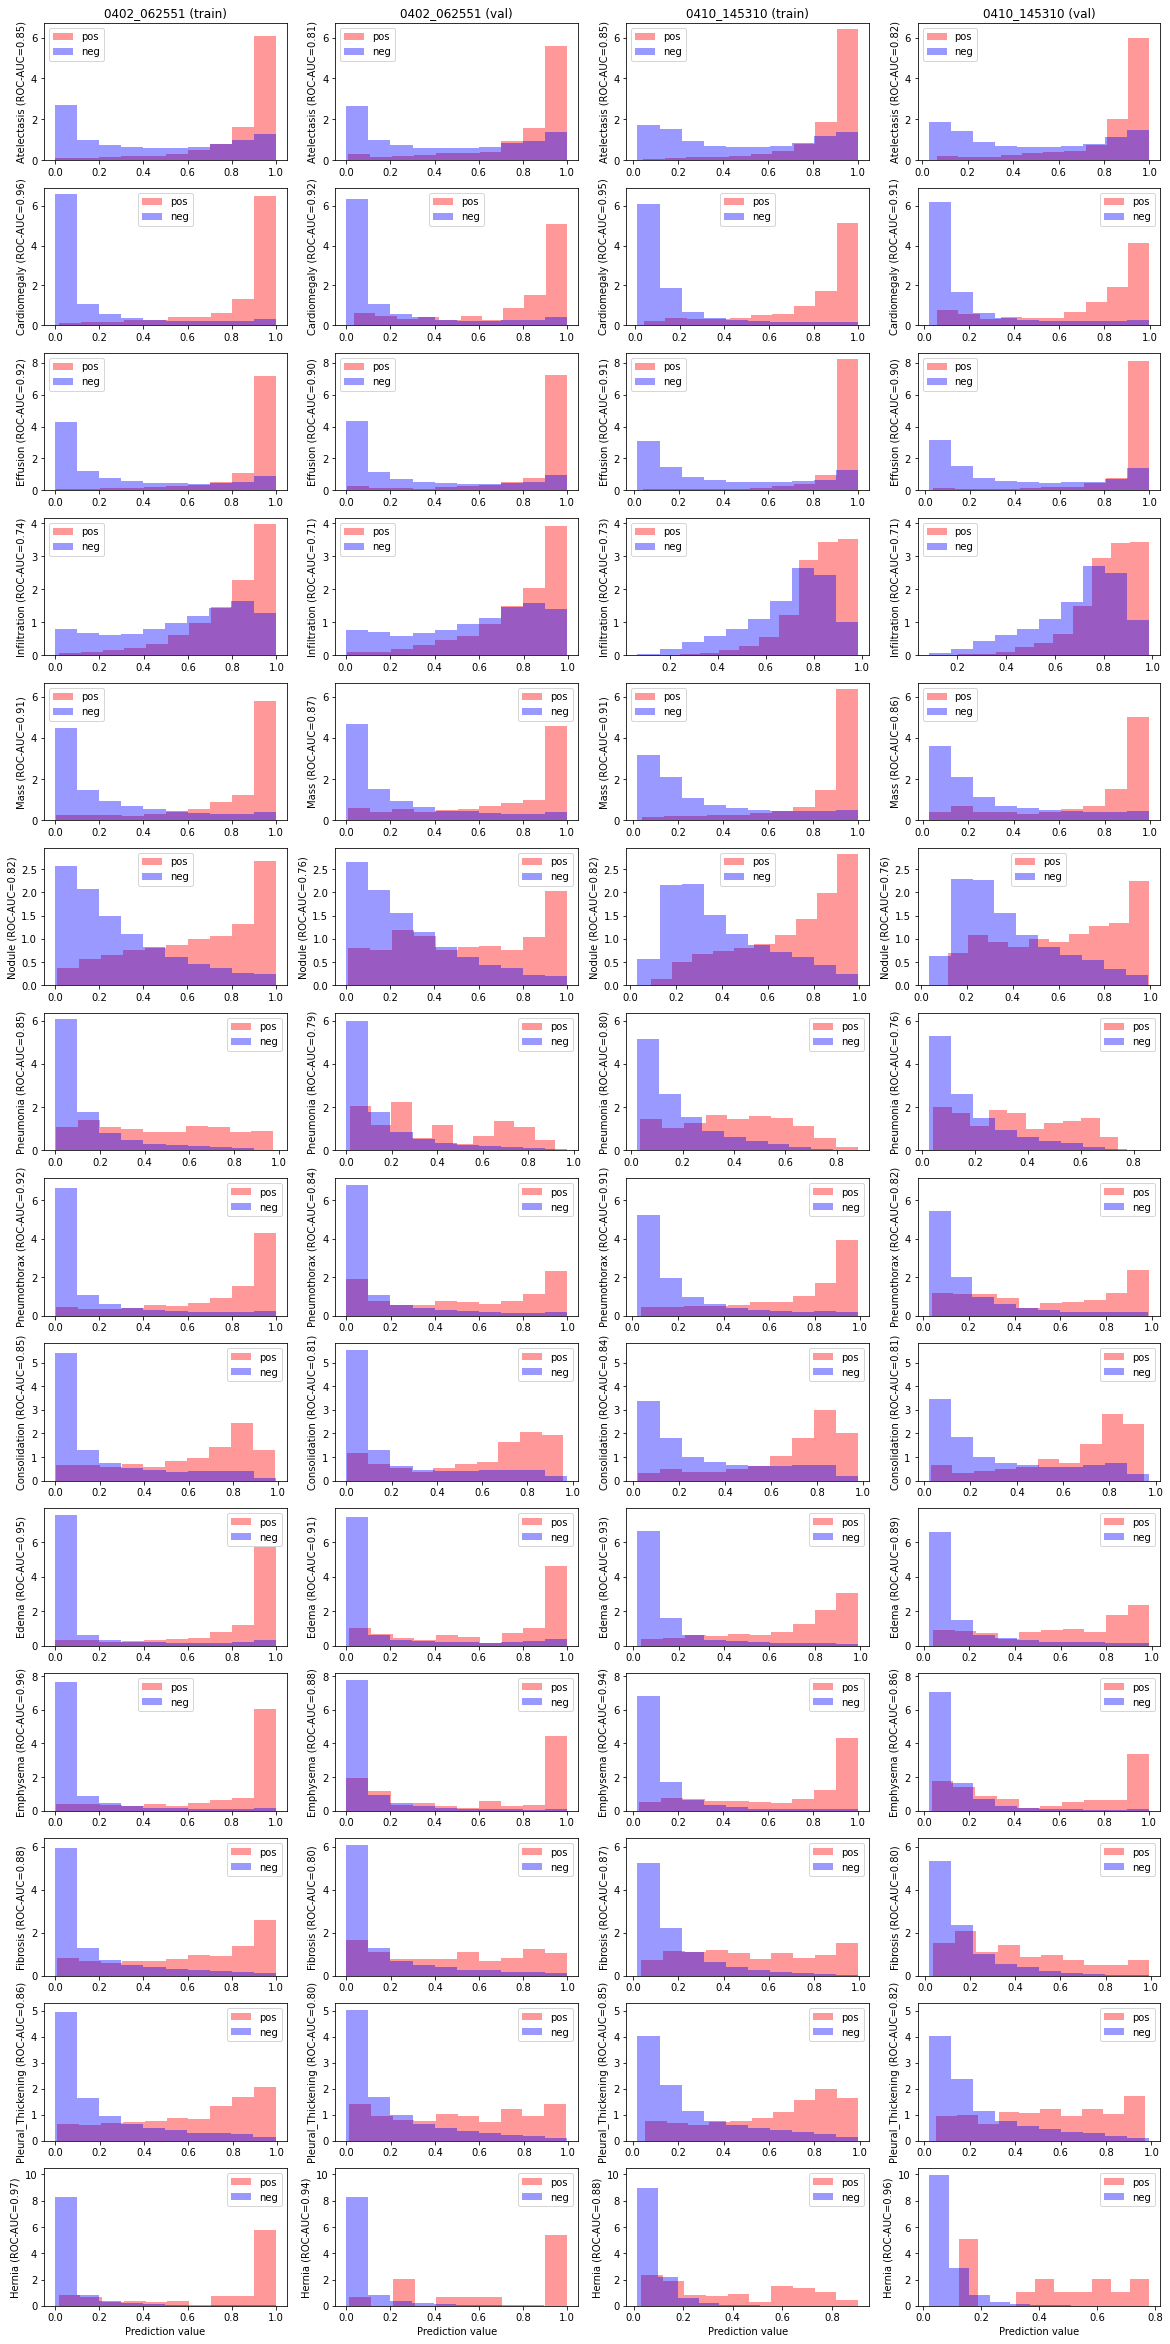

In [34]:
plot_distributions(run_ids, ('train', 'val'))

# Covid examples

In [ ]:
LABELS = ['covid', 'non-c', 'normal']

## Example 1: Covid-UC, size 512, frontal only

In [ ]:
results = load_results('0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid', 'covid-uc_size512_frontal')
list(zip(*results))[0]

In [ ]:
result = results[0][1]
result

In [ ]:
cm = result['all']['cm']

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-X (frontal only)', percentage=False)

## Example 2: Covid-X + Covid-UC

In [ ]:
results = load_results('0722_201835_covid-uc_densenet-121_lr0.0001_os-max10_aug_pre-covid-x')
list(zip(*results))[0]

In [ ]:
cm = results[0][1]['val']['cm']

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-X + UC', percentage=False)

## Example 3

In [ ]:
results = load_results('0722_193534_covid-uc_densenet-121_lr0.0001_os-max10_aug_size256')
list(zip(*results))[0]

In [ ]:
cm = results[0][1]['val']['cm']

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-UC', percentage=False)

## Example 4: winner

In [ ]:
results = load_results('0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid')
list(zip(*results))[0]

In [ ]:
cm = results[0][1]['test']['cm']

In [ ]:
plot_cm(cm, labels=['covid', 'pneumonia', 'normal'], title='Covid-X', percentage=False)